# Load Dataset


In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d ejlok1/cremad

 99% 448M/451M [00:12<00:00, 40.7MB/s]
100% 451M/451M [00:12<00:00, 38.7MB/s]


In [ ]:
! unzip /content/cremad.zip

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
  inflating: AudioWAV/1031_DFA_DIS_XX.wav  
  inflating: AudioWAV/1031_DFA_FEA_XX.wav  
  inflating: AudioWAV/1031_DFA_HAP_XX.wav  
  inflating: AudioWAV/1031_DFA_NEU_XX.wav  
  inflating: AudioWAV/1031_DFA_SAD_XX.wav  
  inflating: AudioWAV/1031_IEO_ANG_HI.wav  
  inflating: AudioWAV/1031_IEO_ANG_LO.wav  
  inflating: AudioWAV/1031_IEO_ANG_MD.wav  
  inflating: AudioWAV/1031_IEO_DIS_HI.wav  
  inflating: AudioWAV/1031_IEO_DIS_LO.wav  
  inflating: AudioWAV/1031_IEO_DIS_MD.wav  
  inflating: AudioWAV/1031_IEO_FEA_HI.wav  
  inflating: AudioWAV/1031_IEO_FEA_LO.wav  
  inflating: AudioWAV/1031_IEO_FEA_MD.wav  
  inflating: AudioWAV/1031_IEO_HAP_HI.wav  
  inflating: AudioWAV/1031_IEO_HAP_LO.wav  
  inflating: AudioWAV/1031_IEO_HAP_MD.wav  
  inflating: AudioWAV/1031_IEO_NEU_XX.wav  
  inflating: AudioWAV/1031_IEO_SAD_HI.wav  
  inflating: AudioWAV/1031_IEO_SAD_LO.wav  
  inflating: AudioWAV/1031_IEO_SAD_MD.wav  
  inflating: AudioW

In [ ]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

100% 429M/429M [00:05<00:00, 64.0MB/s]
100% 429M/429M [00:05<00:00, 88.0MB/s]


In [ ]:
! unzip /content/ravdess-emotional-speech-audio.zip

In [ ]:
! kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

 97% 414M/428M [00:03<00:00, 166MB/s]
100% 428M/428M [00:03<00:00, 120MB/s]


In [ ]:
! unzip /content/toronto-emotional-speech-set-tess.zip

In [ ]:
! kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee

 90% 97.0M/107M [00:00<00:00, 110MB/s]
100% 107M/107M [00:01<00:00, 109MB/s] 


In [ ]:
! unzip /content/surrey-audiovisual-expressed-emotion-savee.zip

# Import Lib

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Paths for data.
Ravdess = "/content/audio_speech_actors_01-24/"
Crema = "/content/AudioWAV/"
Tess = "/content/TESS Toronto emotional speech set data/"
Savee = "/content/ALL/"

**1. Ravdess Dataframe**

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,sad,/content/audio_speech_actors_01-24/Actor_17/03...
1,happy,/content/audio_speech_actors_01-24/Actor_17/03...
2,fear,/content/audio_speech_actors_01-24/Actor_17/03...
3,disgust,/content/audio_speech_actors_01-24/Actor_17/03...
4,angry,/content/audio_speech_actors_01-24/Actor_17/03...


**2. Crema DataFrame**

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,disgust,/content/AudioWAV/1050_TAI_DIS_XX.wav
1,disgust,/content/AudioWAV/1011_IEO_DIS_HI.wav
2,sad,/content/AudioWAV/1060_IWL_SAD_XX.wav
3,disgust,/content/AudioWAV/1082_MTI_DIS_XX.wav
4,happy,/content/AudioWAV/1017_WSI_HAP_XX.wav


**3. TESS dataset**

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,sad,/content/TESS Toronto emotional speech set dat...
1,sad,/content/TESS Toronto emotional speech set dat...
2,sad,/content/TESS Toronto emotional speech set dat...
3,sad,/content/TESS Toronto emotional speech set dat...
4,sad,/content/TESS Toronto emotional speech set dat...


**4. CREMA-D dataset**

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,neutral,/content/ALL/DC_n23.wav
1,neutral,/content/ALL/JE_n06.wav
2,angry,/content/ALL/DC_a07.wav
3,neutral,/content/ALL/JE_n07.wav
4,neutral,/content/ALL/DC_n04.wav


In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,sad,/content/audio_speech_actors_01-24/Actor_17/03...
1,happy,/content/audio_speech_actors_01-24/Actor_17/03...
2,fear,/content/audio_speech_actors_01-24/Actor_17/03...
3,disgust,/content/audio_speech_actors_01-24/Actor_17/03...
4,angry,/content/audio_speech_actors_01-24/Actor_17/03...


# Data Visualisation and Exploration

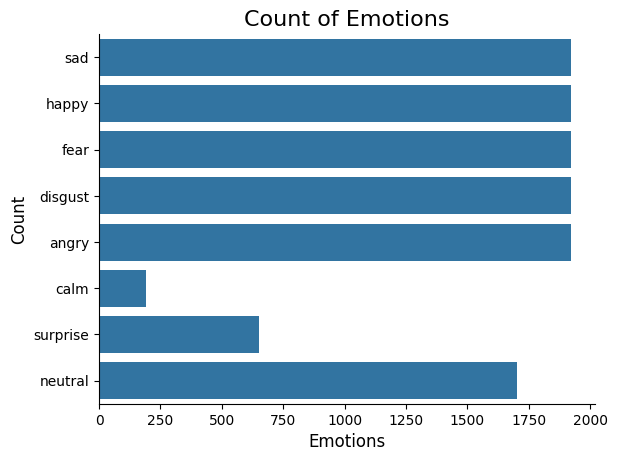

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

# Data Augmentation


In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)


In [ ]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

# Feature Extraction

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    print(data)
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    print(data)
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.150354,0.624576,0.674887,0.678589,0.641566,0.663368,0.664876,0.643163,0.704465,0.743704,...,0.000188,0.000213,0.000215,0.000182,0.000179,0.000208,0.000202,0.000116,0.000013,sad
1,0.352069,0.806625,0.848911,0.829713,0.809348,0.824287,0.712592,0.707052,0.732642,0.716834,...,0.002492,0.002461,0.002554,0.002576,0.002295,0.002447,0.002582,0.002444,0.002421,sad
2,0.140441,0.618823,0.631625,0.669891,0.659031,0.603355,0.627343,0.633338,0.660780,0.708948,...,0.000047,0.000036,0.000041,0.000047,0.000046,0.000053,0.000057,0.000025,0.000002,sad
3,0.128915,0.642151,0.716766,0.721779,0.705146,0.684352,0.664358,0.633857,0.654594,0.652815,...,0.000047,0.000059,0.000071,0.000084,0.000121,0.000128,0.000135,0.000075,0.000006,happy
4,0.204432,0.686534,0.764108,0.763100,0.739646,0.716925,0.669131,0.660042,0.697166,0.674214,...,0.000049,0.000061,0.000073,0.000087,0.000124,0.000130,0.000138,0.000078,0.000008,happy


# Data Preparation

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

# Modelling

In [ ]:
from tensorflow.keras.optimizers import Adam

model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 81, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 41, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 21, 128)          

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

286/286 [==============================] - 17s 61ms/step - loss: 1.1217 - accuracy: 0.6023
Accuracy of our model on test data :  60.22801995277405 %


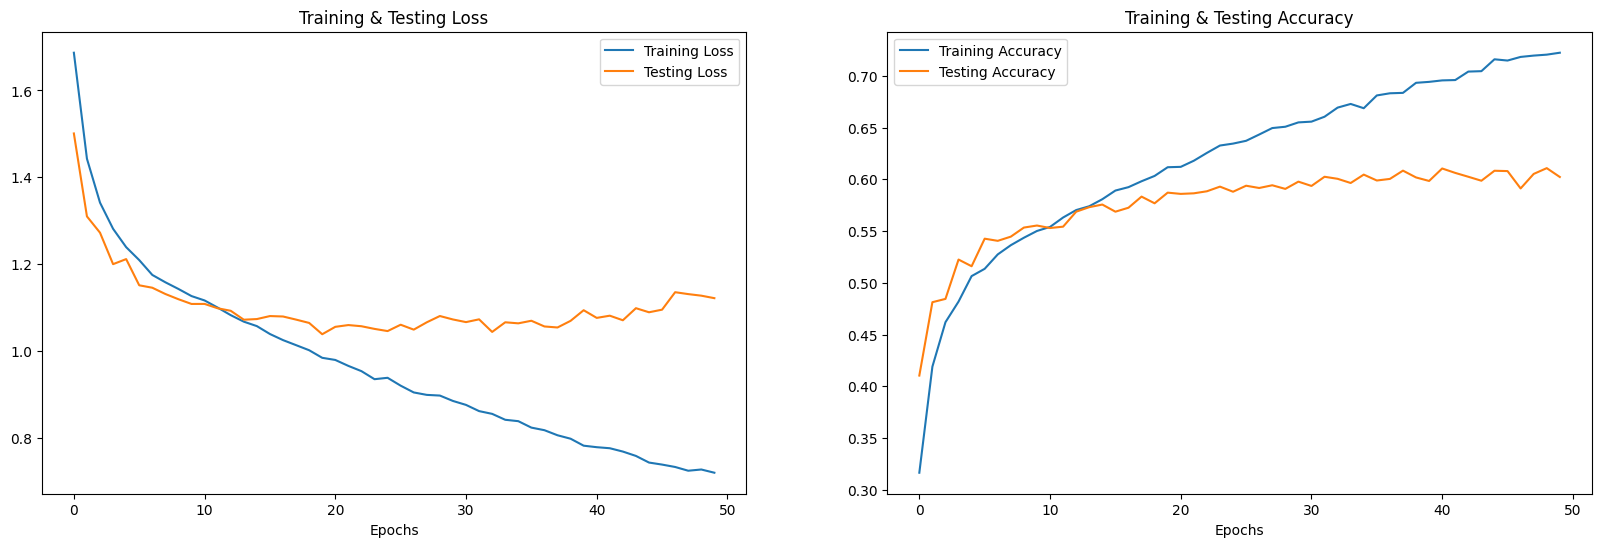

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 30s 105ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fear,fear
1,neutral,neutral
2,sad,sad
3,disgust,sad
4,sad,sad
5,happy,happy
6,calm,calm
7,disgust,disgust
8,sad,sad
9,disgust,happy


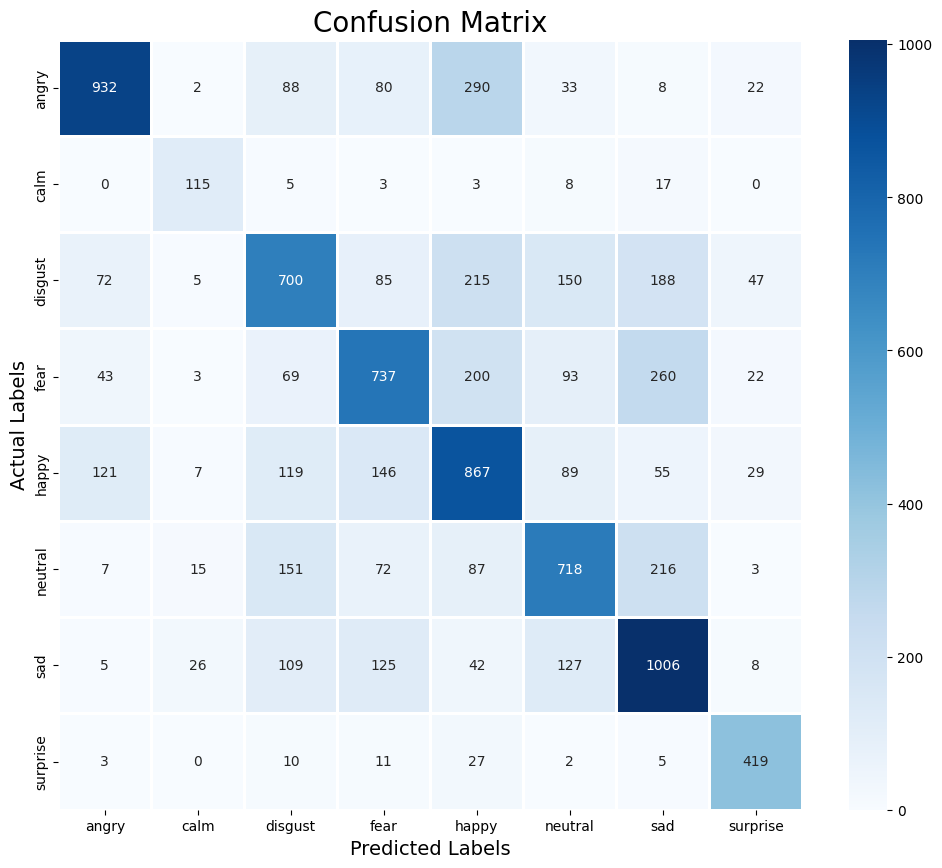

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.64      0.71      1455
        calm       0.66      0.76      0.71       151
     disgust       0.56      0.48      0.52      1462
        fear       0.59      0.52      0.55      1427
       happy       0.50      0.61      0.55      1433
     neutral       0.59      0.57      0.58      1269
         sad       0.57      0.69      0.63      1448
    surprise       0.76      0.88      0.82       477

    accuracy                           0.60      9122
   macro avg       0.63      0.64      0.63      9122
weighted avg       0.61      0.60      0.60      9122

